checking out the mesh samplers... using https://github.com/yt-project/yt/pull/4398 to sample multiple points at once

### 3D, linear, hexahedral mesh element

8 nodes, check check yt/utilities/mesh_types.yaml for node ordering for vert ordering 

signature for `sample_at_real_points`: 

returns sample values array:
```python
 def sample_at_real_points(self,
                               np.float64_t[:,::1] vertices,
                               np.float64_t[::1] field_values,
                               np.float64_t[:,::1] positions):
```


In [1]:
#  3D, linear, hexahedral mesh element has 8 nodes 
import numpy as np
from yt.utilities.lib.element_mappings import Q1Sampler3D, Q1Sampler2D
import matplotlib.pyplot as plt 

hex_sampler = Q1Sampler3D() 


verts = [[0., 0., 0.], 
         [1., 0., 0.], 
         [1., 1., 0.], 
         [0., 1., 0.],
         [0., 0., 1.], 
         [1., 0., 1.], 
         [1., 1., 1.], 
         [0., 1., 1.]]
verts = np.array(verts)

field_vals = np.random.random((8,))

positions_to_sample = verts.copy() # should return exact


sampled_values = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
assert(np.allclose(sampled_values, field_vals))


# set field values to vary from one side to the other 
field_vals = np.full((8,), 5.) * (verts[:,2] == 1)

# sample along z, should vary linearly from 0 to 5.
nsamples = 100
y_samples = np.full((nsamples,), 0.5)
x_samples = np.full((nsamples,), 0.5)
z_samples = np.linspace(0,1,nsamples)

positions_to_sample = np.column_stack([x_samples, y_samples, z_samples])
positions_to_sample.shape
sampled_values = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
assert(np.allclose(sampled_values, z_samples * 5.0))


### plot within the element

In [2]:

x0 = np.linspace(0,1,20)
y0 = np.linspace(0,1,25)
z0 = np.full((10,),0.5)
xg, yg, zg = np.meshgrid(x0, y0, z0, indexing='ij')
positions_to_sample = np.column_stack([xg.ravel(), yg.ravel(), zg.ravel()])

field_vals = np.random.random((8,))
sampled_values = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
sampled_values = sampled_values.reshape(xg.shape)

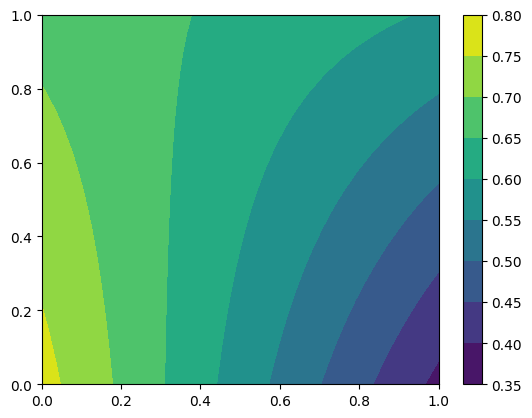

In [3]:
import matplotlib.pyplot as plt 

plt.contourf(y0, x0, sampled_values[:,:,0])
plt.colorbar()

In [4]:
# element coordinate system goes -1, to 1 in all: 

units = hex_sampler.map_reals_to_unit(verts, positions_to_sample)
units

array([[-1., -1.,  0.],
       [-1., -1.,  0.],
       [-1., -1.,  0.],
       ...,
       [ 1.,  1.,  0.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  0.]])

In [5]:
units.shape

(5000, 3)

### use the unit position to mask samples outside element

In [6]:
# pick some points outside the verts
x0 = np.linspace(-1,2,10)
y0 = np.linspace(-2,4,25)
z0 = np.full((11,),0.5)
xg, yg, zg = np.meshgrid(x0, y0, z0, indexing='ij')
positions_to_sample = np.column_stack([xg.ravel(), yg.ravel(), zg.ravel()])


# unit_poss = hex_sampler.map_reals_to_unit(verts, positions_to_sample)
pos_mask = hex_sampler.check_contains(verts, positions_to_sample)
# pos_mask = (unit_poss >= -1.) & (unit_poss <=1.)
# pos_mask = np.all(pos_mask, axis=1)
pos_mask.shape

(2750,)

In [7]:
pos_mask.sum()

220

In [8]:
samples = hex_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
samples[pos_mask==0] = np.nan
samples = samples.reshape(xg.shape)

In [9]:
samples.shape

(10, 25, 11)

In [10]:
slc = samples[:,:,0]
slc.shape

(10, 25)

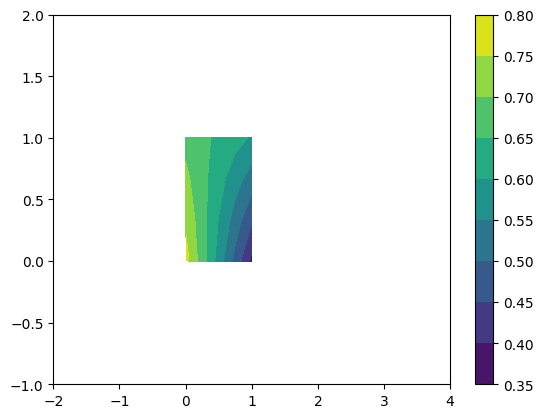

In [11]:
import matplotlib.pyplot as plt 

plt.contourf(y0, x0, samples[:,:,0])
plt.colorbar()

## linear 2d triangular element 


In [12]:
from yt.utilities.lib.element_mappings import P1Sampler2D

In [13]:
tri_sampler = P1Sampler2D()

In [14]:
verts = [[0., 0.], 
         [1., 0.], 
         [0.5, 1.]]
verts = np.array(verts)

field_vals = np.random.random((3,))

x0 = np.linspace(0,1,99)
y0 = np.linspace(0,1,100)
xg, yg = np.meshgrid(x0, y0, indexing='ij')

positions_to_sample = np.column_stack([xg.ravel(), yg.ravel()])

unit_pos = tri_sampler.map_reals_to_unit(verts, positions_to_sample)

barycentric coords go from 0 to 1 along each dim

In [15]:
pos_mask = tri_sampler.check_contains(verts, positions_to_sample)
# pos_mask = (unit_pos >= 0) & (unit_pos <= 1)
# pos_mask = np.all(pos_mask, axis=1)

In [16]:
np.sum(pos_mask == 0 )

4998

In [17]:
samples = tri_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
samples[pos_mask==0] = np.nan 
samples = samples.reshape(xg.shape)

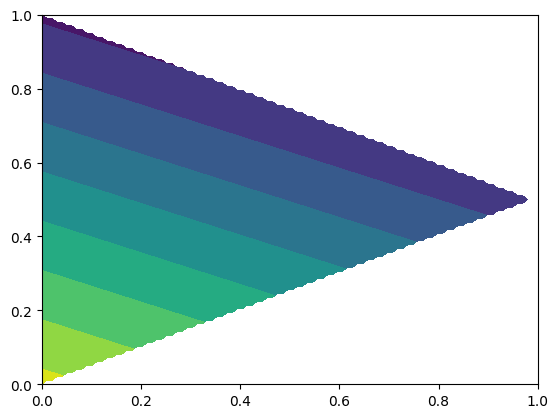

In [18]:
plt.contourf(y0, x0, samples)

## 2D Quad

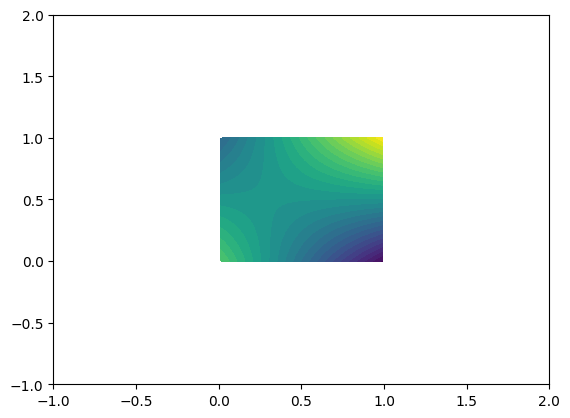

In [21]:
import numpy as np
from yt.utilities.lib.element_mappings import Q1Sampler2D
import matplotlib.pyplot as plt 

quad_sampler = Q1Sampler2D()
verts = [[0., 0.,], 
         [1., 0.,], 
         [1., 1.,], 
         [0., 1.,]]
verts = np.array(verts)

field_vals = np.random.random((4,))

x0 = np.linspace(-1,2, 99)
y0 = np.linspace(-1,2, 100)
xg, yg = np.meshgrid(x0, y0)
positions_to_sample = np.column_stack([xg.ravel(), yg.ravel()])

pos_mask = quad_sampler.check_contains(verts, positions_to_sample)

sampled_vals = quad_sampler.sample_at_real_points(verts, field_vals, positions_to_sample)
sampled_vals[pos_mask==0] = np.nan
sampled_vals = sampled_vals.reshape(xg.shape)
plt.contourf(x0, y0, sampled_vals, 30)